In [23]:
import os
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerics

from scipy.interpolate import griddata


from skimage import io
from natsort import natsorted
#import skimage.io
import skimage.color
import skimage.morphology
import skimage.measure as sm

from skimage.io import imread
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from skimage import (io, filters,  morphology, measure, segmentation, feature, util, exposure)
from scipy.ndimage import gaussian_filter 
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom

import trackpy as tp

In [2]:
# Load multiple images. Example taken from https://scikit-image.org/docs/dev/user_guide/getting_started.html

plt.rcParams['figure.figsize'] = [10,10]

folder_path = './Images/MDCK-pos1/'
list_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
list_files = natsorted(list_files)
image_list = []
# Filename fc2_save_2023-03-22-182010-0NNN.tif
for filename in list_files:
    image_list.append(io.imread(filename))

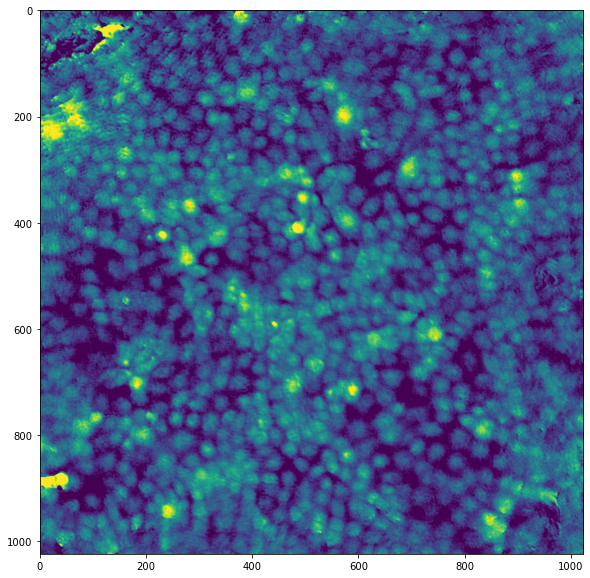

In [3]:
plt.imshow(image_list[0])

Number of images in a stack: 301


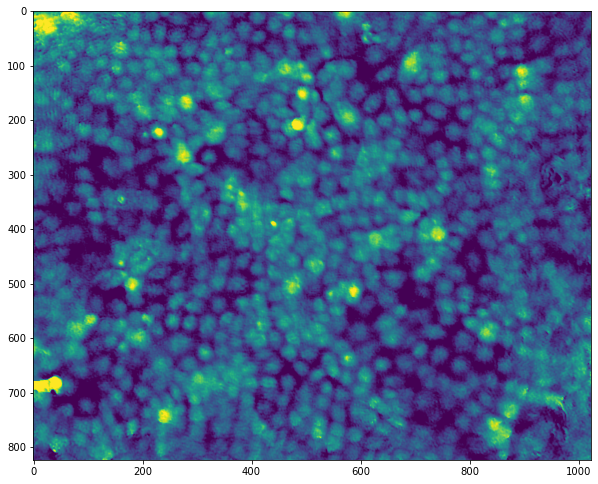

In [4]:
full_images_cropped = [] #crop 0-200 along y-axis but keep the full x-axis
for i in range(len(image_list)):
    full_images_cropped.append(image_list[i][200:, :]) 
print("Number of images in a stack:", len(full_images_cropped))

plt.imshow(full_images_cropped[0])

In [5]:
full_images_cropped_blurred = []
for i in range(len(full_images_cropped)):
    full_images_cropped_blurred.append(filters.gaussian(full_images_cropped[i], sigma = 3)) #used to be sigma = 1.7

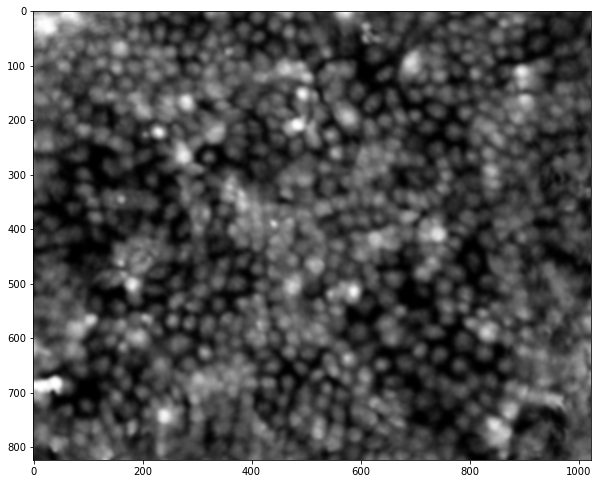

In [6]:
plt.imshow(full_images_cropped_blurred[0], cmap=plt.cm.gray)

Frame 0: 718 features


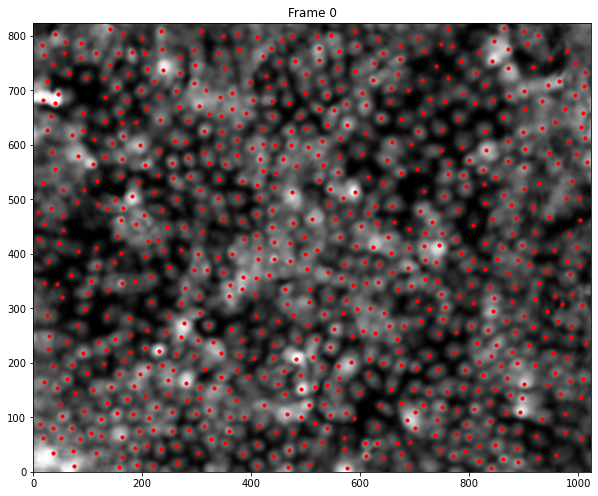

In [17]:
# Locate features (cells) in the first frame just to see what it looks like and adjust parameters if need be!
feature_radius = 17  # Adjust this parameter based on the size of your cells
min_mass = 0.5    # Adjust this parameter based on the brightness of your cells
batch = [full_images_cropped_blurred[0]]
frames = tp.batch(batch, feature_radius, minmass=min_mass)

# Assuming you have already detected features and stored them in the 'frames' DataFrame
# 'frame_number' should be the index of the specific frame you want to analyze

# Select the features detected in the desired frame
desired_frame_number = 0  # Change this to the frame you want to analyze
features_in_frame = frames[frames['frame'] == desired_frame_number]

# Load the corresponding frame from 'cropped_images' (assuming it's a list of frames)
desired_frame = full_images_cropped_blurred[desired_frame_number]

# Plot the original frame
plt.figure()
plt.imshow(desired_frame, cmap='gray')  # Assuming grayscale images

# Overlay the detected features on the frame
plt.scatter(features_in_frame['x'], features_in_frame['y'], c='red', s=10)  # Adjust color and size as needed

# Set axis limits to match the frame size
plt.xlim(0, desired_frame.shape[1])
plt.ylim(0, desired_frame.shape[0])

# Add a title with the frame number
plt.title(f"Frame {desired_frame_number}")

# Display or save the frame with detected features
plt.show()


Frame 300: 799 features


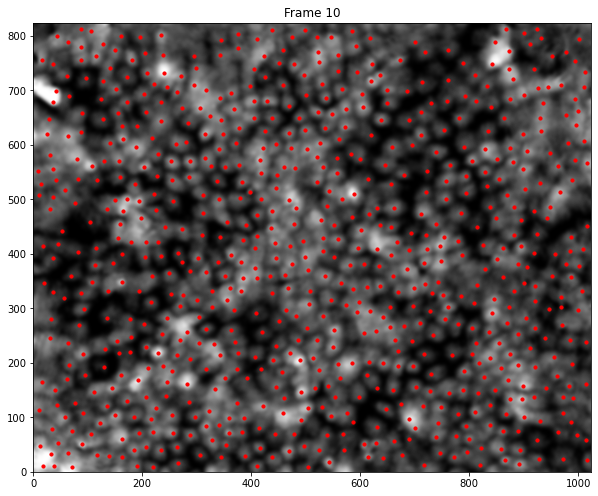

In [14]:
# Locate features (cells) in the first frame just to see what it looks like and adjust parameters if need be!
feature_radius = 17  # Adjust this parameter based on the size of your cells
min_mass = 0.5     # Adjust this parameter based on the brightness of your cells
# batch = [full_images_cropped_blurred[2]]
frames = tp.batch(full_images_cropped_blurred, feature_radius, minmass=min_mass)

# Assuming you have already detected features and stored them in the 'frames' DataFrame
# 'frame_number' should be the index of the specific frame you want to analyze

# Select the features detected in the desired frame
desired_frame_number = 10  # Change this to the frame you want to analyze
features_in_frame = frames[frames['frame'] == desired_frame_number]

# Load the corresponding frame from 'cropped_images' (assuming it's a list of frames)
desired_frame = full_images_cropped_blurred[desired_frame_number]

# Plot the original frame
plt.figure()
plt.imshow(desired_frame, cmap='gray')  # Assuming grayscale images

# Overlay the detected features on the frame
plt.scatter(features_in_frame['x'], features_in_frame['y'], c='red', s=10)  # Adjust color and size as needed

# Set axis limits to match the frame size
plt.xlim(0, desired_frame.shape[1])
plt.ylim(0, desired_frame.shape[0])

# Add a title with the frame number
plt.title(f"Frame {desired_frame_number}")

# Display or save the frame with detected features
plt.show()


In [18]:
feature_radius = 17  # Adjust this parameter based on the size of your cells
min_mass = 0.5     # Adjust this parameter based on the brightness of your cells
frames = tp.batch(full_images_cropped_blurred, feature_radius, minmass=min_mass) #identifying most of the cells in the entire stack of images

Frame 300: 799 features


In [19]:
# Link features to create tracks
max_displacement = 10  # Maximum distance features can move between frames
memory = 20   # Maximum number of frames that a feature can disappear and reappear
tracks = tp.link_df(frames, max_displacement, memory=memory)

Frame 300: 799 trajectories present.


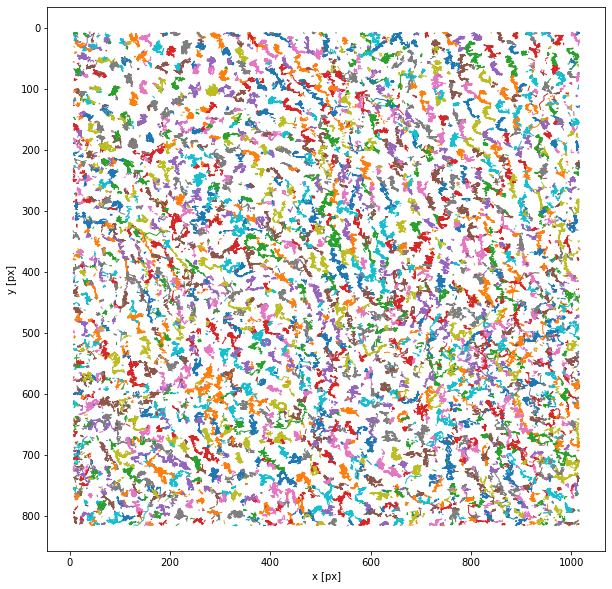

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [20]:
plt.figure()
# tp.plot_traj(tracks)
tp.plot_traj(tracks)

In [22]:
displacements = tp.relate_frames(tracks, 0, 1)

#do this for all frames in the stack 
for i in range(0, len(full_images_cropped_blurred)):
    displacements = displacements.append(tp.relate_frames(tracks, i, i+1))

In [47]:
#print shape of cropped full images 
print("Shape of cropped full images:", np.shape(full_images_cropped_blurred))

Shape of cropped full images: (301, 824, 1024)


In [61]:
delta_t = 300 #time between frames in seconds - need to change that ? check with the lab images 

# Calculate velocity components
displacements['vx'] = displacements['dx'] / delta_t
displacements['vy'] = displacements['dy'] / delta_t

#Define the spatial dimensions of the image
x_min, x_max = 0, full_images_cropped_blurred[0].shape[1]
y_min, y_max = 0, full_images_cropped_blurred[1].shape[0]

#Create a grid
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, 30), np.arange(y_min, y_max, 30)) #Luiza changed the resolution: this is to make it less or more coarse-grained!
# Interpolate velocity components onto the grid

#pick out the x and y coordinates of the first frame only 
velocity_field_x0 = griddata((displacements['x'][0], displacements['y'][0]), displacements['vx'][0], (x_grid, y_grid), method='linear')
velocity_field_y0 = griddata((displacements['x'][0], displacements['y'][0]), displacements['vy'][0], (x_grid, y_grid), method='linear')

#interpolating for all time points 
velocity_field_x = griddata((displacements['x'], displacements['y']), displacements['vx'], (x_grid, y_grid), method='linear')
velocity_field_y = griddata((displacements['x'], displacements['y']), displacements['vy'], (x_grid, y_grid), method='linear')


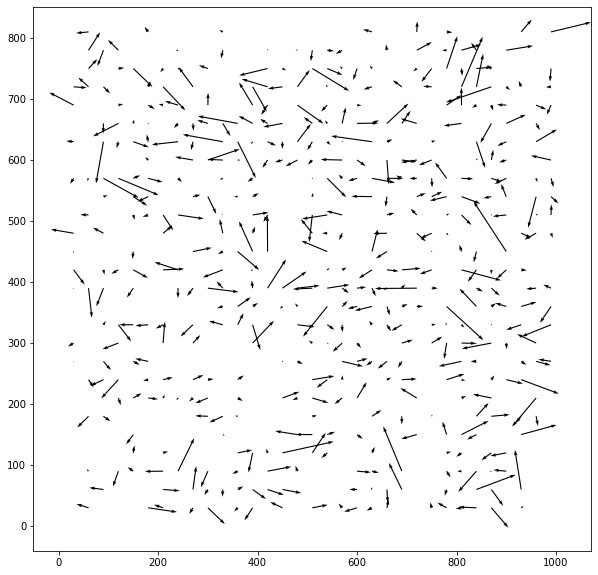

In [62]:
# Create a quiver plot for the velocity field (time averaged as we are plotting all of the arrows for velocities at once, aka for all time steps)
# plt.figure()
plt.quiver(x_grid, y_grid, velocity_field_x, velocity_field_y, scale=0.25, width=0.0020)
# tp.plot_traj(tracks)